# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
# прочитали данные
import pandas as pd
data = pd.read_csv('spam_or_not_spam.csv')

In [2]:
#нашли распределение для каждого класса
data['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

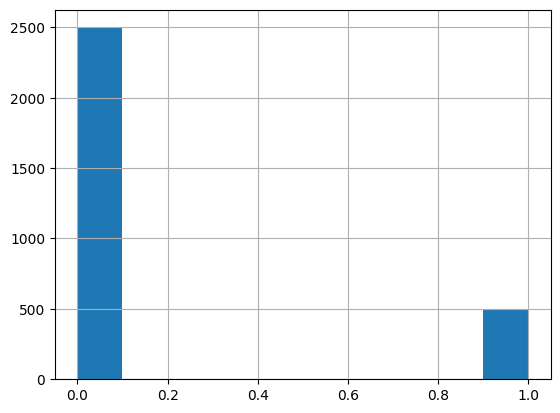

In [3]:
# визуализировали результат
import matplotlib as plt
h = data['label'].hist()
fig = h.get_figure()
# очевидно, что данные несбалансированы

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

Замените все пустоты (пустые строки) в данных на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [5]:
import numpy as np
data = data.replace('', np.nan, regex=False)
data = data.dropna()

Переводим данные в векторный вид:

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [7]:
X.shape

(2999, 34116)

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [8]:
X
y = data['label']

Разделите выборку на обучающую и тестовую, размер тестовой выборки возьмите как 0.25, параметр random_state определите со значением 42:

In [9]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [10]:
y_test.mean()

0.164

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [11]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB(alpha=0.01)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [12]:
from unicodedata import digit
from sklearn import metrics
print(metrics.classification_report(y_test, y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.997     0.997     0.997       627
           1      0.984     0.984     0.984       123

    accuracy                          0.995       750
   macro avg      0.990     0.990     0.990       750
weighted avg      0.995     0.995     0.995       750



Нарисуйте ROC-кривую:

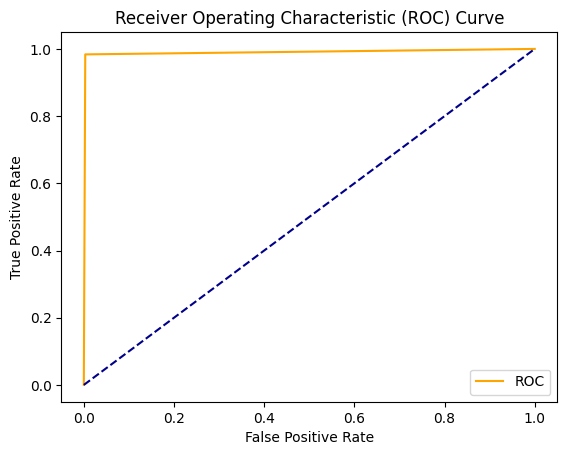

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

mnb_auc = roc_auc_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

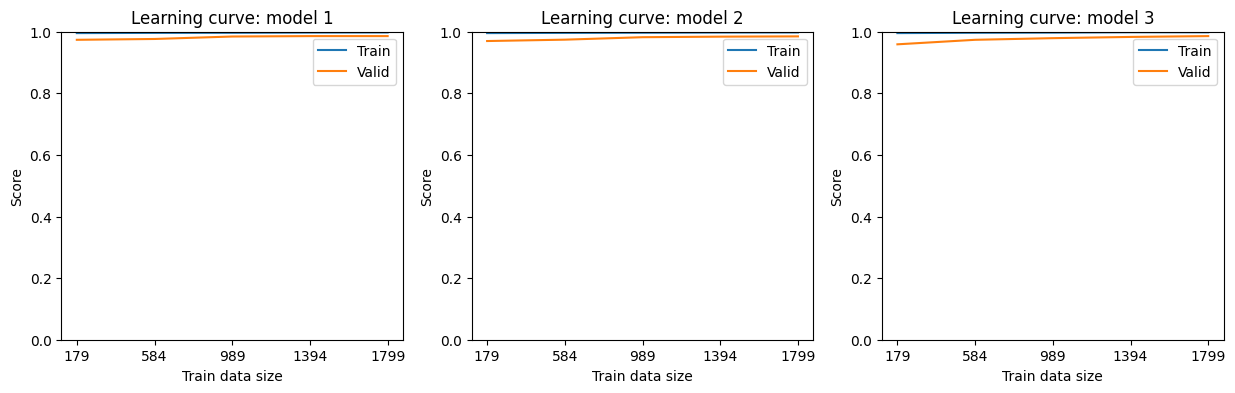

In [14]:
from sklearn import model_selection

def plot_learning_curve(model, X, y, cv, scoring="accuracy", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X_train,  # матрица наблюдений X
        y=y_train,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="accuracy",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()


models = [
    ComplementNB(alpha=0.01),
    ComplementNB(alpha=0.005),
    ComplementNB(alpha=0.001),
]

#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')

Я проверила несколько мерик, accuracy и precision практически не отличаются друг от друга судя по графикам, f1 незначительно отличается. Можно сделать вывод, что в данном случае от параметра alpha качество классификации не сильно зависит.